In [64]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [75]:

CFG = {
    'NBITS':2048,
    'SEED':42,
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../open/train.csv')  # 예시 파일 이름
chembl_data.head()

train = chembl_data[['Smiles', 'pIC50']]
train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)

train_x = np.stack(train['Fingerprint'].values)
train_y = train['pIC50'].values



# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=300, 
    random_state=CFG['SEED']
)
model.fit(train_x, train_y)


def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)



# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
train_y_pred = model.predict(train_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')
r2_val = r2_score(val_y,val_y_pred)
r2_train = r2_score(train_y, train_y_pred)
print(f'R2_val: {r2_val}')
print(f'R2_train: {r2_train}')

test = pd.read_csv('../open/test.csv')
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)

test_x = np.stack(test['Fingerprint'].values)

test_y_pred = model.predict(test_x)

submit = pd.read_csv('../open/sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

submit.to_csv('../open/baseline_submit.csv', index=False)


/tmp/ipykernel_351/2930311617.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)


RMSE: 1925.7767147663099
R2_val: 0.7051788010091529
R2_train: 0.9557871678499443


In [76]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

CFG = {
    'NBITS':2048,
    'SEED':42,
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=CFG['NBITS'])
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../open/train.csv')  # 예시 파일 이름
chembl_data.head()

train = chembl_data[['Smiles', 'pIC50']]
train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)

train_x = np.stack(train['Fingerprint'].values)
train_y = train['pIC50'].values



# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [10, 20, 30, None],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# 모델 설정
rf = RandomForestRegressor(random_state=CFG['SEED'])

# Grid Search 수행
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(train_x, train_y)

# 최적의 파라미터와 점수 출력
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# 최적의 파라미터로 예측 및 평가
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(val_x)

mse = mean_squared_error(val_y, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


/tmp/ipykernel_351/3791676534.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Fingerprint'] = train['Smiles'].apply(smiles_to_fingerprint)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

KeyboardInterrupt: 

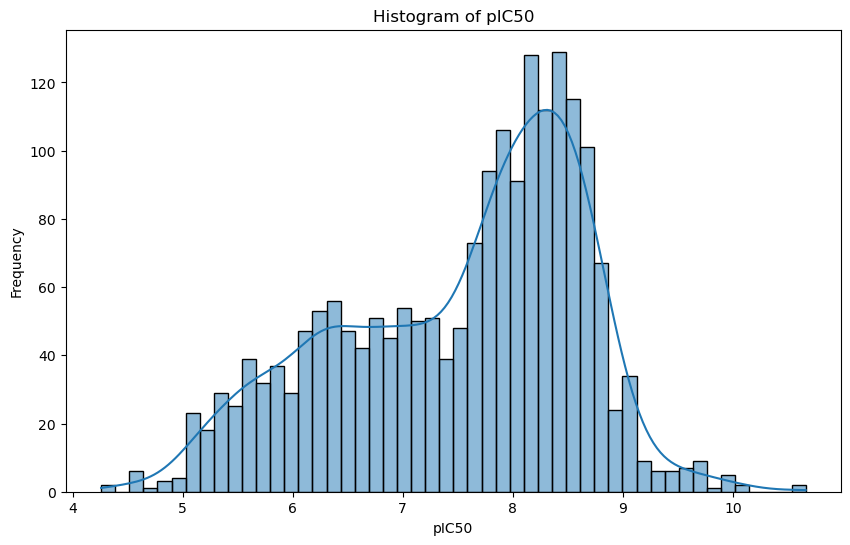

In [66]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(train['pIC50'], bins=50, kde=True)
plt.title('Histogram of pIC50')
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.show()


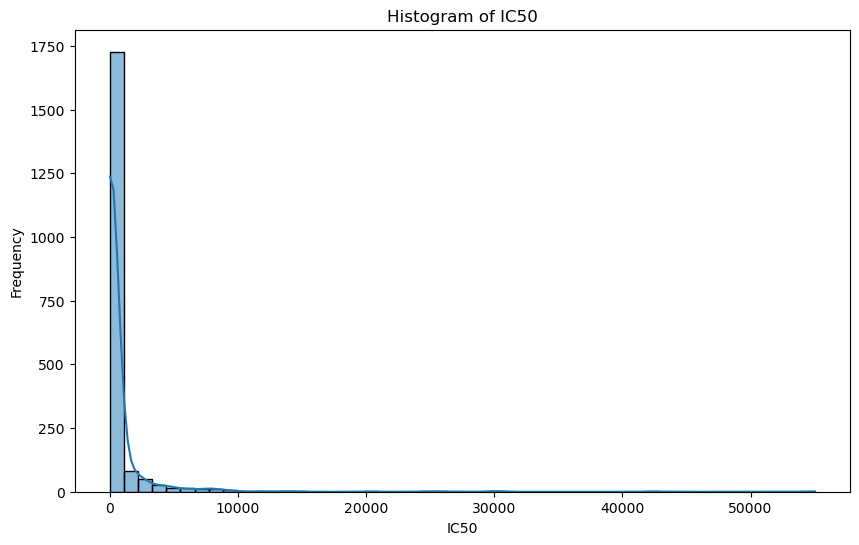

In [67]:
pr = chembl_data['IC50_nM']
plt.figure(figsize= (10,6))
# 히스토그램 생성

sns.histplot(pr, bins=50, kde=True)
plt.title('Histogram of IC50')
plt.xlabel('IC50')
plt.ylabel('Frequency')
plt.show()


RMSE: 2152.6360346372694
R2: 0.6646042117477655
